# Avoiding Overfitting in Image Classification

_By: Harsh Kumar, Gojek_  
_13th July 20204_  

Reference: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

## Import libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import v2

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


## Get training and validation data

We will be using CIFAR10 dataset which has images of 10 categories

Names of the classes which are part of the data

In [8]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Define transformations of input images  
- Convert data to tensors  
- Normalize values

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

NOTE: Shuffle has been turned off for training dataset as well.  
In this notebook, we want to use the same subset of images to train the model in every epoch, so that overfitting is clearly detectable

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
valset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


NOTE: Since shuffle is turned off, we will get images in the same sequence from trainloader. We will restrict the number of training images to first 8000 (2000 batches of 4 images each). This will allow us to clearly show overfitting

In [6]:
subset_indices = list(range(8000))
trainsubset = torch.utils.data.Subset(trainset, subset_indices)
# valsubset = torch.utils.data.Subset(valset, subset_indices)

In [3]:
batch_size = 4

In [7]:
trainloader = torch.utils.data.DataLoader(trainsubset, batch_size=batch_size, shuffle=False, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)

### Display sample images

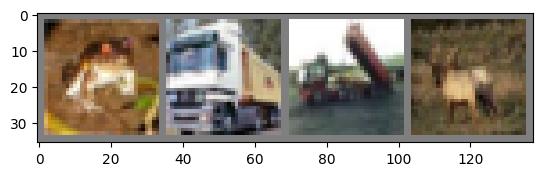

frog  truck truck deer 


In [9]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Define model structure

In [10]:
class ImgClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
model = ImgClassifier()
model.to(device)

ImgClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Train the Model

Define Optimizer and Loss Function

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [13]:
n_epochs = 20

In [14]:
def train_model_batches(
    model: ImgClassifier,
    trainloader: torch.utils.data.DataLoader
) -> (ImgClassifier, float):
    """
    Returns trained model for a fixed number of batches along with the training loss 
    """
    train_loss_cumm = 0.0
    for i, data_train in enumerate(trainloader, 0):
        # Start training
        model.train()
        
        # get the inputs; data is a list of [inputs, labels]
        inputs_train, labels_train = data_train[0].to(device), data_train[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        labels_train_pred = model(inputs_train)
        loss = loss_fn(labels_train_pred, labels_train)
        loss.backward()
        optimizer.step()

        train_loss_cumm += loss.item()
    
    batch_count = i

    # Loss value is calculated per batch
    return model, train_loss_cumm / batch_count

In [15]:
def get_val_loss(model: ImgClassifier, valloader: torch.utils.data.DataLoader) -> float:
    """
    Returns loss value on validation dataset for the given model
    """
    loss_val_total = 0
    
    # Since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, data_val in enumerate(valloader, 0):
            inputs_val, labels_val = data_val[0].to(device), data_val[1].to(device)
            
            # Calculate predicted labels by running images through the network
            labels_pred_val = model(inputs_val)
            loss_val = loss_fn(labels_pred_val, labels_val)
            loss_val_total += loss_val.item()

    val_batch_count = i

    # Loss value is calculated per batch
    return loss_val_total / val_batch_count

In [16]:
train_loss_list=[]
val_loss_list=[]

# Loop over the dataset multiple times
for epoch in range(n_epochs):  

    model, train_loss = train_model_batches(model, trainloader)

    # Calculate loss over validation data
    val_loss = get_val_loss(model, valloader)
    
    # Save value of loss in a list to evaluate loss values later
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
    print(f'[{epoch + 1}] loss: {train_loss:.3f} val_loss: {val_loss:.3f}')

print('Finished Training')

[1] loss: 2.153 val_loss: 1.922
[2] loss: 1.829 val_loss: 1.686
[3] loss: 1.654 val_loss: 1.568
[4] loss: 1.542 val_loss: 1.512
[5] loss: 1.452 val_loss: 1.464
[6] loss: 1.367 val_loss: 1.444
[7] loss: 1.286 val_loss: 1.451
[8] loss: 1.196 val_loss: 1.488
[9] loss: 1.104 val_loss: 1.515
[10] loss: 1.014 val_loss: 1.567
[11] loss: 0.917 val_loss: 1.684
[12] loss: 0.829 val_loss: 1.876
[13] loss: 0.759 val_loss: 1.961
[14] loss: 0.694 val_loss: 2.124
[15] loss: 0.671 val_loss: 2.290
[16] loss: 0.632 val_loss: 2.499
[17] loss: 0.579 val_loss: 2.472
[18] loss: 0.543 val_loss: 2.815
[19] loss: 0.482 val_loss: 2.944
[20] loss: 0.453 val_loss: 3.091
Finished Training


### Plot Loss

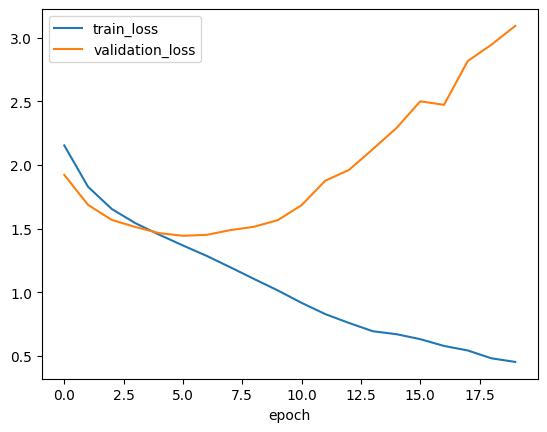

In [17]:
def plot_loss(train_loss_list, val_loss_list):
    df_loss = pd.DataFrame({"train_loss":train_loss_list, "validation_loss":val_loss_list})
    df_loss["epoch"] = df_loss.index
    
    axs = plt.subplot()
    df_loss.plot(x="epoch", y="train_loss", ax=axs)
    df_loss.plot(x="epoch", y="validation_loss", ax=axs)

plot_loss(train_loss_list, val_loss_list)

### Accuracy on Validation Data

In [18]:
def get_accuracy_val_data(model: ImgClassifier, valloader: torch.utils.data.DataLoader) -> float:
    correct = 0
    total = 0
    # Since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data_val in valloader:
            images, labels = data_val[0].to(device), data_val[1].to(device)
            # calculate outputs by running images through the network
            labels_pred = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(labels_pred.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

val_accuracy = get_accuracy_val_data(model, valloader)

print(f'Accuracy on the val images: {100 * val_accuracy:.2f} %')

Accuracy on the val images: 43.86 %


## Early Stopping
Stop training when validation loss stops reducing 

Re-iniatialize model

In [19]:
model = ImgClassifier()
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [20]:
# Path to store the model
MODEL_PATH = './cifar_model.pth'

Train the model

In [21]:
train_loss_list=[]
val_loss_list=[]

# loop over the dataset multiple times
for epoch in range(n_epochs):  

    model, train_loss = train_model_batches(model, trainloader)

    # Calculate loss over validation data
    val_loss = get_val_loss(model, valloader)
    
    # Save value of loss in a list to evaluate loss values later
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
    print(f'[{epoch + 1}] loss: {train_loss:.3f} val_loss: {val_loss:.3f}', end=" ")

    # Early Stopping Criteria
    # No need to check early checking criteria till we have atleast 3 epochs
    if len(val_loss_list)<3:
        print("-> Nothing to do")
    elif val_loss_list[-1] < val_loss_list[-2]:
        # Save the model if there is a reduction in loss on val data
        torch.save(model.state_dict(), MODEL_PATH)
        print("-> Saved Model")
    elif (val_loss_list[-1] >= val_loss_list[-2]) and (val_loss_list[-2] >= val_loss_list[-3]):
        print("-> Early Stopping")
        break
    else:
        print("-> Nothing to do")

print('Finished Training')

[1] loss: 2.164 val_loss: 1.975 -> Nothing to do
[2] loss: 1.869 val_loss: 1.718 -> Nothing to do
[3] loss: 1.668 val_loss: 1.589 -> Saved Model
[4] loss: 1.543 val_loss: 1.517 -> Saved Model
[5] loss: 1.441 val_loss: 1.464 -> Saved Model
[6] loss: 1.351 val_loss: 1.442 -> Saved Model
[7] loss: 1.261 val_loss: 1.433 -> Saved Model
[8] loss: 1.176 val_loss: 1.442 -> Nothing to do
[9] loss: 1.084 val_loss: 1.450 -> Early Stopping
Finished Training


### Plot Loss

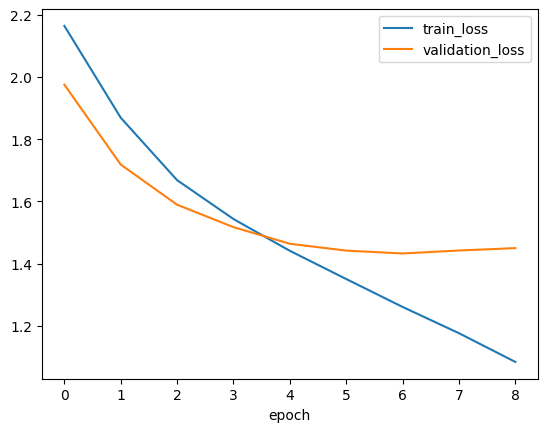

In [22]:
plot_loss(train_loss_list, val_loss_list)

### Accuracy on Validation Data

In [23]:
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [24]:
val_accuracy = get_accuracy_val_data(model, valloader)

print(f'Accuracy on the val images: {100 * val_accuracy:.2f} %')

Accuracy on the val images: 48.23 %


## Dropout
Randomly ignoring a fraction of neurons during training  
Pytorch Documentation: https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html

Define model with Dropout

In [25]:
class ImgClassifierDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.1)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(120, 84)
        self.dropout = nn.Dropout(0.2)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [26]:
model = ImgClassifierDropout()
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Train the model

In [27]:
train_loss_list=[]
val_loss_list=[]

# loop over the dataset multiple times
for epoch in range(n_epochs):  

    model, train_loss = train_model_batches(model, trainloader)

    # Calculate loss over validation data
    val_loss = get_val_loss(model, valloader)
    
    # Save value of loss in a list to evaluate loss values later
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
    print(f'[{epoch + 1}] loss: {train_loss:.3f} val_loss: {val_loss:.3f}')

print('Finished Training')

[1] loss: 2.213 val_loss: 2.062
[2] loss: 1.978 val_loss: 1.897
[3] loss: 1.818 val_loss: 1.747
[4] loss: 1.717 val_loss: 1.713
[5] loss: 1.668 val_loss: 1.646
[6] loss: 1.606 val_loss: 1.623
[7] loss: 1.566 val_loss: 1.599
[8] loss: 1.528 val_loss: 1.588
[9] loss: 1.493 val_loss: 1.566
[10] loss: 1.450 val_loss: 1.542
[11] loss: 1.435 val_loss: 1.547
[12] loss: 1.398 val_loss: 1.528
[13] loss: 1.370 val_loss: 1.618
[14] loss: 1.350 val_loss: 1.546
[15] loss: 1.328 val_loss: 1.559
[16] loss: 1.315 val_loss: 1.545
[17] loss: 1.301 val_loss: 1.560
[18] loss: 1.276 val_loss: 1.534
[19] loss: 1.268 val_loss: 1.510
[20] loss: 1.235 val_loss: 1.523
Finished Training


### Plot Loss

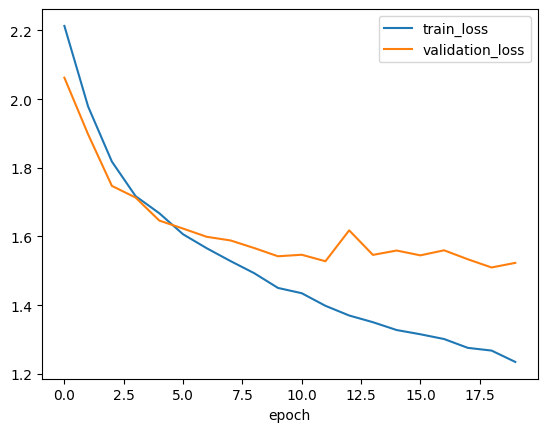

In [28]:
plot_loss(train_loss_list, val_loss_list)

### Accuracy on Validation Data

In [29]:
val_accuracy = get_accuracy_val_data(model, valloader)

print(f'Accuracy on the val images: {100 * val_accuracy:.2f} %')

Accuracy on the val images: 46.11 %


## L2 Regularization

Pytorch only offers L2 regularization out of the box through a `weight_decay` parameter for most of the optimizers

Reusing the earlier model, but with an updated optimizer

In [30]:
model = ImgClassifier()
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)

Train the model

In [31]:
train_loss_list=[]
val_loss_list=[]

# loop over the dataset multiple times
for epoch in range(n_epochs):  

    model, train_loss = train_model_batches(model, trainloader)

    # Calculate loss over validation data
    val_loss = get_val_loss(model, valloader)
    
    # Save value of loss in a list to evaluate loss values later
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
    print(f'[{epoch + 1}] loss: {train_loss:.3f} val_loss: {val_loss:.3f}')

print('Finished Training')

[1] loss: 2.227 val_loss: 2.038
[2] loss: 1.951 val_loss: 1.848
[3] loss: 1.785 val_loss: 1.694
[4] loss: 1.668 val_loss: 1.619
[5] loss: 1.590 val_loss: 1.565
[6] loss: 1.532 val_loss: 1.520
[7] loss: 1.484 val_loss: 1.487
[8] loss: 1.443 val_loss: 1.463
[9] loss: 1.407 val_loss: 1.446
[10] loss: 1.374 val_loss: 1.438
[11] loss: 1.344 val_loss: 1.423
[12] loss: 1.315 val_loss: 1.421
[13] loss: 1.287 val_loss: 1.412
[14] loss: 1.261 val_loss: 1.409
[15] loss: 1.233 val_loss: 1.407
[16] loss: 1.207 val_loss: 1.403
[17] loss: 1.178 val_loss: 1.411
[18] loss: 1.152 val_loss: 1.410
[19] loss: 1.124 val_loss: 1.413
[20] loss: 1.096 val_loss: 1.416
Finished Training


### Plot Loss

**NOTE: The gain from batch normalization seems to be low, probably due to very small batch size (4).  
Small batch sizes can result in inaccurate estimation of mean and standard deviation**

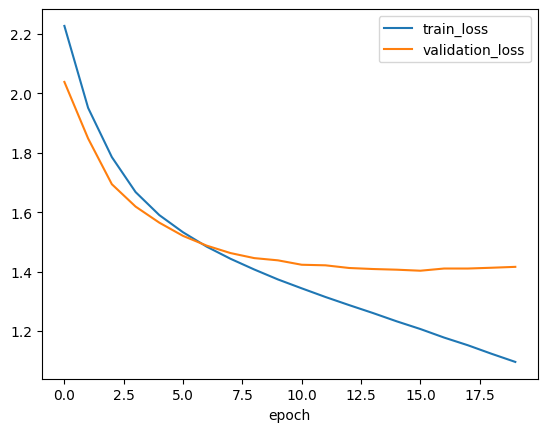

In [32]:
plot_loss(train_loss_list, val_loss_list)

### Accuracy on Validation Data

In [33]:
val_accuracy = get_accuracy_val_data(model, valloader)

print(f'Accuracy on the val images: {100 * val_accuracy:.2f} %')

Accuracy on the val images: 50.27 %


## Batch Normalization
Batch Normalization (BatchNorm) is a technique to improve training stability and speed up convergence. It involves normalizing the inputs to a layer in a neural network by scaling the activations. The normalization is performed across a mini-batch of data during training.

- Pytorch Documentation for Normalization Layers: https://pytorch.org/docs/stable/nn.html#normalization-layers
- Pytorch Documentation for BatchNorm1d: https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d

Define model with Batch Normalization

In [34]:
class ImgClassifierBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.bn3 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.bn3(F.relu(self.fc1(x)))
        x = self.bn4(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [35]:
model = ImgClassifierBatchNorm()
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Train the model

In [36]:
train_loss_list=[]
val_loss_list=[]

# loop over the dataset multiple times
for epoch in range(n_epochs):  

    model, train_loss = train_model_batches(model, trainloader)

    # Calculate loss over validation data
    val_loss = get_val_loss(model, valloader)
    
    # Save value of loss in a list to evaluate loss values later
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
    print(f'[{epoch + 1}] loss: {train_loss:.3f} val_loss: {val_loss:.3f}')

print('Finished Training')

[1] loss: 2.159 val_loss: 2.083
[2] loss: 2.024 val_loss: 1.970
[3] loss: 1.995 val_loss: 2.041
[4] loss: 1.985 val_loss: 1.959
[5] loss: 1.890 val_loss: 1.916
[6] loss: 1.869 val_loss: 1.904
[7] loss: 1.846 val_loss: 1.897
[8] loss: 1.797 val_loss: 1.883
[9] loss: 1.799 val_loss: 1.902
[10] loss: 1.743 val_loss: 1.884
[11] loss: 1.692 val_loss: 1.874
[12] loss: 1.641 val_loss: 1.873
[13] loss: 1.611 val_loss: 1.883
[14] loss: 1.563 val_loss: 1.905
[15] loss: 1.523 val_loss: 1.917
[16] loss: 1.495 val_loss: 1.950
[17] loss: 1.460 val_loss: 1.942
[18] loss: 1.389 val_loss: 1.985
[19] loss: 1.432 val_loss: 1.998
[20] loss: 1.387 val_loss: 2.009
Finished Training


### Plot Loss

**NOTE: The gain from batch normalization seems to be low, probably due to very small batch size (4).  
Small batch sizes can result in inaccurate estimation of mean and standard deviation**

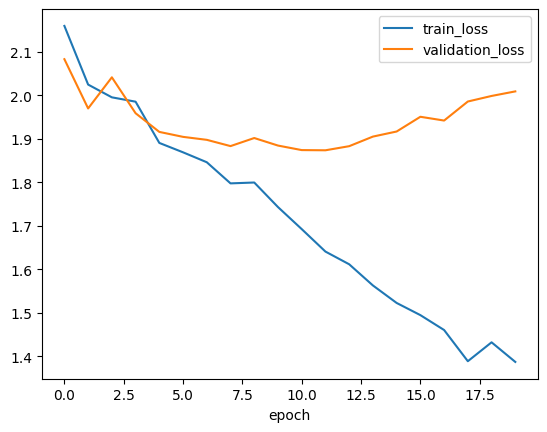

In [37]:
plot_loss(train_loss_list, val_loss_list)

### Accuracy on Validation Data

In [38]:
val_accuracy = get_accuracy_val_data(model, valloader)

print(f'Accuracy on the val images: {100 * val_accuracy:.2f} %')

Accuracy on the val images: 34.30 %


## Data Augmentation

### Demonstrate data augmentation

Show Original Images

frog  truck truck deer 


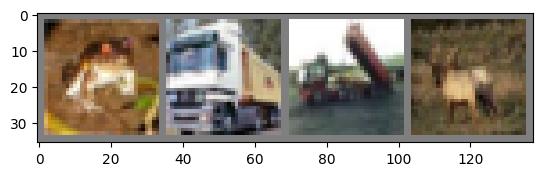

In [39]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# print labels and show images
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
imshow(torchvision.utils.make_grid(images))

Show transformed images

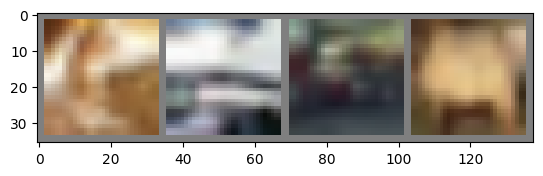

In [40]:
# Define transformations
transforms = v2.Compose([
    v2.RandomResizedCrop(size=(32, 32), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
])

# show images
imshow(torchvision.utils.make_grid(transforms(images)))

### Training the model with augmented data

Reusing the earlier model

In [41]:
model = ImgClassifier()
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Train the model

In [42]:
def actual_train(inputs, labels_train):
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    labels_train_pred = model(inputs)
    loss = loss_fn(labels_train_pred, labels_train)
    loss.backward()
    optimizer.step()

    return loss.item()

In [45]:
def train_model_batches_augment(
    model: ImgClassifier,
    trainloader: torch.utils.data.DataLoader
) -> (ImgClassifier, float):
    """
    Returns trained model for a fixed number of batches along with the training loss 
    """
    train_loss_cumm = 0.0
    for i, data_train in enumerate(trainloader, 0):
        # Start training
        model.train()
        
        # get the inputs; data is a list of [inputs, labels]
        inputs_train, labels_train = data_train[0].to(device), data_train[1].to(device)

        # train with original images
        train_loss_cumm += actual_train(inputs_train, labels_train)

        # train with randomly transformed images a few times
        for k in range(2):
            transforms = v2.Compose([
                v2.RandomResizedCrop(size=(32, 32), antialias=True),
                v2.RandomHorizontalFlip(p=0.5),
                # v2.ToDtype(torch.float32, scale=True),
                # v2.Normalize(mean=[random(), random(), random()], std=[random(), random(), random()]),
            ])
            train_loss_cumm += actual_train(transforms(inputs_train), labels_train)

    batch_count = i

    # Loss value is calculated per batch
    return model, train_loss_cumm / (batch_count*(1+2))

In [46]:
train_loss_list=[]
val_loss_list=[]

# loop over the dataset multiple times
for epoch in range(n_epochs):  

    model, train_loss = train_model_batches_augment(model, trainloader)

    # Calculate loss over validation data
    val_loss = get_val_loss(model, valloader)
    
    # Save value of loss in a list to evaluate loss values later
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
    print(f'[{epoch + 1}] loss: {train_loss:.3f} val_loss: {val_loss:.3f}')

print('Finished Training')

[1] loss: 2.109 val_loss: 1.858
[2] loss: 1.867 val_loss: 1.683
[3] loss: 1.751 val_loss: 1.567
[4] loss: 1.692 val_loss: 1.527
[5] loss: 1.633 val_loss: 1.568
[6] loss: 1.604 val_loss: 1.502
[7] loss: 1.563 val_loss: 1.456
[8] loss: 1.528 val_loss: 1.468
[9] loss: 1.502 val_loss: 1.437
[10] loss: 1.488 val_loss: 1.482
[11] loss: 1.451 val_loss: 1.437
[12] loss: 1.428 val_loss: 1.436
[13] loss: 1.412 val_loss: 1.432
[14] loss: 1.393 val_loss: 1.479
[15] loss: 1.381 val_loss: 1.471
[16] loss: 1.370 val_loss: 1.491
[17] loss: 1.353 val_loss: 1.471
[18] loss: 1.340 val_loss: 1.473
[19] loss: 1.323 val_loss: 1.487
[20] loss: 1.327 val_loss: 1.515
Finished Training


### Plot Loss

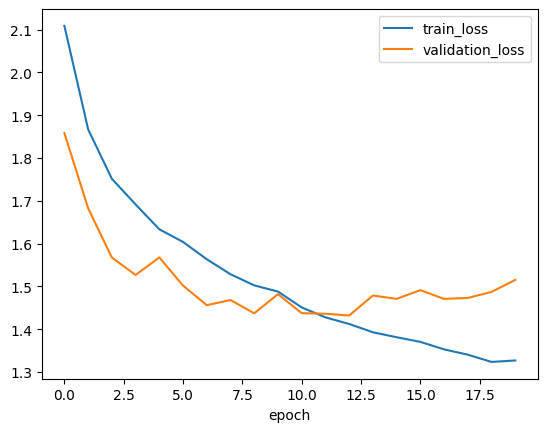

In [47]:
plot_loss(train_loss_list, val_loss_list)

### Accuracy on Validation Data

In [48]:
val_accuracy = get_accuracy_val_data(model, valloader)

print(f'Accuracy on the val images: {100 * val_accuracy:.2f} %')

Accuracy on the val images: 52.04 %


## Gradient Clipping
https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html

Reusing the earlier model

In [49]:
model = ImgClassifier()
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Train the model

In [52]:
def train_model_batches_gradient_clip(
    model: ImgClassifier,
    trainloader: torch.utils.data.DataLoader
) -> (ImgClassifier, float):
    """
    Returns trained model for a fixed number of batches along with the training loss 
    """
    train_loss_cumm = 0.0
    for i, data_train in enumerate(trainloader, 0):
        # Start training
        model.train()
        
        # get the inputs; data is a list of [inputs, labels]
        inputs_train, labels_train = data_train[0].to(device), data_train[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        labels_train_pred = model(inputs_train)
        loss = loss_fn(labels_train_pred, labels_train)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        train_loss_cumm += loss.item()

        batch_count = i

    # Loss value is calculated per batch
    return model, train_loss_cumm / batch_count

In [53]:
train_loss_list=[]
val_loss_list=[]

# loop over the dataset multiple times
for epoch in range(n_epochs):  

    model, train_loss = train_model_batches_gradient_clip(model, trainloader)

    # Calculate loss over validation data
    val_loss = get_val_loss(model, valloader)
    
    # Save value of loss in a list to evaluate loss values later
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
    print(f'[{epoch + 1}] loss: {train_loss:.3f} val_loss: {val_loss:.3f}')

print('Finished Training')

[1] loss: 2.245 val_loss: 2.062
[2] loss: 1.980 val_loss: 1.929
[3] loss: 1.869 val_loss: 1.840
[4] loss: 1.786 val_loss: 1.768
[5] loss: 1.713 val_loss: 1.705
[6] loss: 1.651 val_loss: 1.657
[7] loss: 1.602 val_loss: 1.623
[8] loss: 1.563 val_loss: 1.599
[9] loss: 1.534 val_loss: 1.580
[10] loss: 1.509 val_loss: 1.563
[11] loss: 1.487 val_loss: 1.548
[12] loss: 1.467 val_loss: 1.535
[13] loss: 1.449 val_loss: 1.523
[14] loss: 1.433 val_loss: 1.510
[15] loss: 1.417 val_loss: 1.499
[16] loss: 1.402 val_loss: 1.490
[17] loss: 1.388 val_loss: 1.480
[18] loss: 1.374 val_loss: 1.474
[19] loss: 1.361 val_loss: 1.467
[20] loss: 1.348 val_loss: 1.460
Finished Training


### Plot Loss

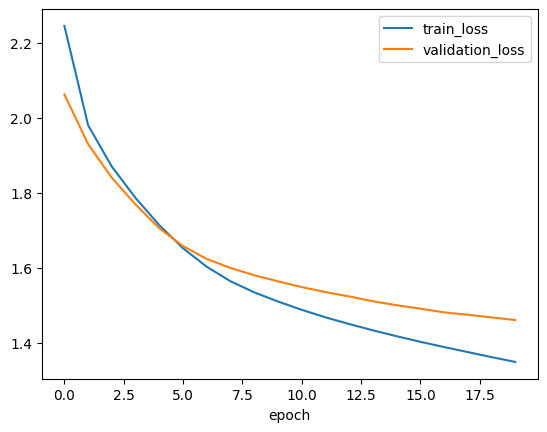

In [54]:
plot_loss(train_loss_list, val_loss_list)

### Accuracy on Validation Data

In [55]:
val_accuracy = get_accuracy_val_data(model, valloader)

print(f'Accuracy on the val images: {100 * val_accuracy:.2f} %')

Accuracy on the val images: 47.86 %
